In [3]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans, AffinityPropagation
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Load the dataset
biomass_data = pd.read_csv('site_data.csv')

# Transpose the DataFrame to have products as rows and locations as columns
data_transposed = biomass_data.set_index(['dataset', 'site_name', 'site_id', 'X', 'Y']).T

# Remove non-numeric rows
data_transposed_numeric = data_transposed.select_dtypes(include=[np.number])

# Replace 'NA' with NaN
data_transposed_numeric = data_transposed_numeric.replace('NA', np.nan)

# Drop columns with all NaN values
data_transposed_numeric = data_transposed_numeric.dropna(axis=1, how='all')

# Impute missing values with column mean
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
data_imputed = data_transposed_numeric.fillna(data_transposed_numeric.mean())

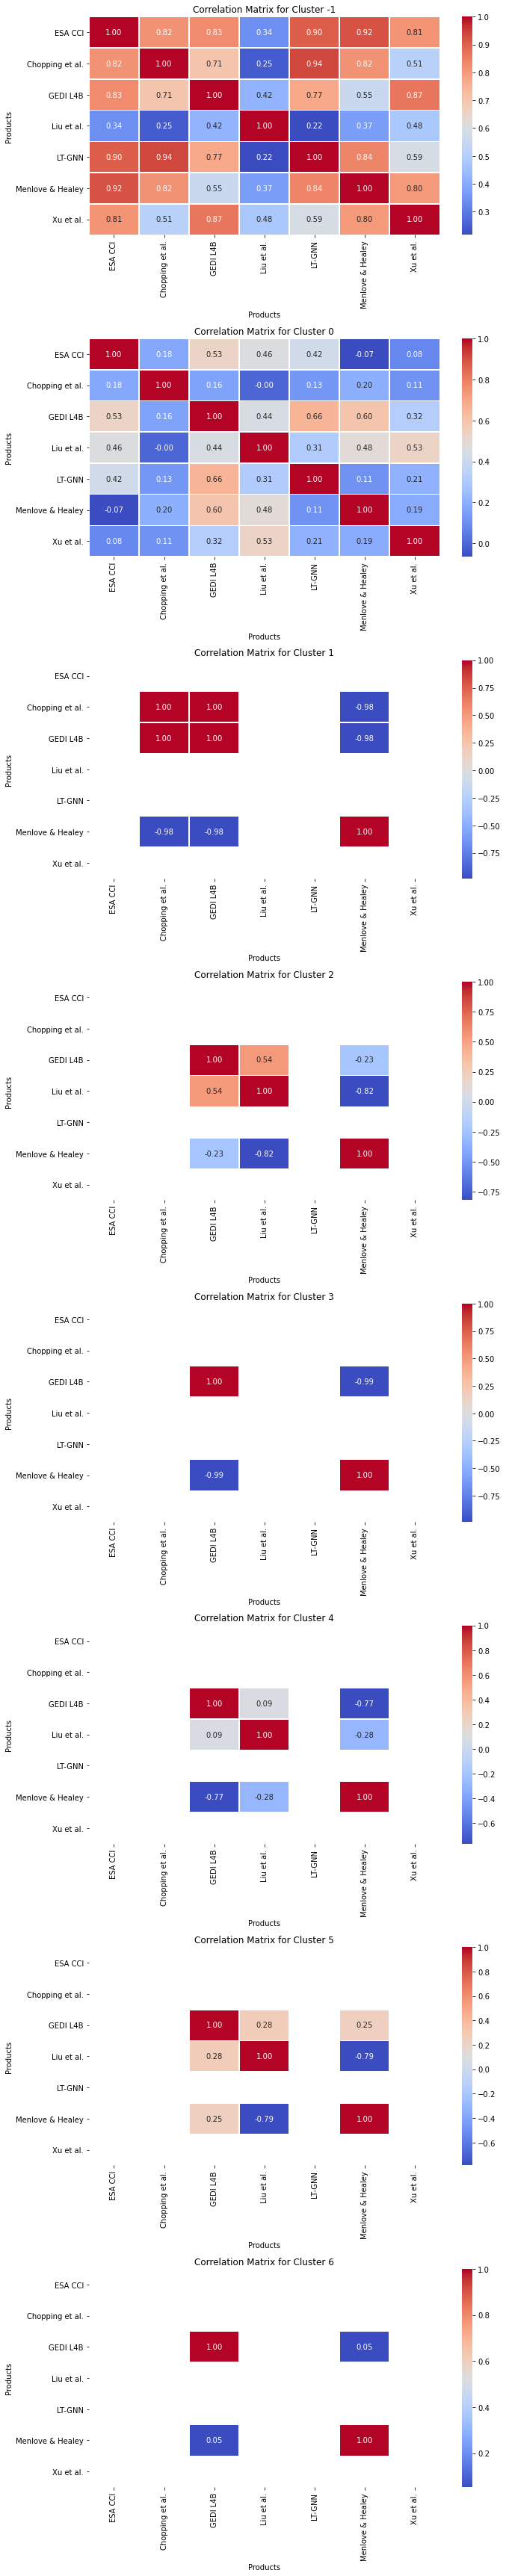

In [16]:
# Assuming your data is in a DataFrame called 'df'
products = ['ESA CCI', 'Chopping et al.', 'GEDI L4B', 'Liu et al.', 'LT-GNN', 'Menlove & Healey', 'Xu et al.']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_imputed.T)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=4)  # Adjust the parameters as needed
clusters = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the DataFrame
data_transposed_numeric.loc['cluster'] = clusters

# Transpose the data back to the original format
biomass_data_clustered = data_transposed_numeric.T.reset_index()

# Convert the data to a DataFrame
df = pd.DataFrame(biomass_data_clustered)

# List of products
products = ['ESA CCI', 'Chopping et al.', 'GEDI L4B', 'Liu et al.', 'LT-GNN', 'Menlove & Healey', 'Xu et al.']

# Create a DataFrame for the heatmap data
heatmap_data = pd.DataFrame(index=products, columns=df['cluster'].unique())

# Group data by cluster
grouped = df.groupby('cluster')

# Create subplots for each cluster
fig, axes = plt.subplots(len(grouped), 1, figsize=(10, 6 * len(grouped)))

# Calculate correlations and plot heatmaps for each cluster
for i, (cluster, data) in enumerate(grouped):
    corr_matrix = data[products].corr()
    sns.heatmap(corr_matrix, ax=axes[i], cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
    axes[i].set_title(f'Correlation Matrix for Cluster {int(cluster)}')
    axes[i].set_xlabel('Products')
    axes[i].set_ylabel('Products')

plt.tight_layout()


In [ ]:
# Create a dictionary to store the products for each cluster
cluster_products = {}

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    cluster = row['cluster']
    if cluster not in cluster_products:
        cluster_products[cluster] = []

    # Check each product and add it to the cluster if it has a non-NaN value
    for product in products:
        if not pd.isna(row[product]) and product not in cluster_products[cluster]:
            cluster_products[cluster].append(product)

# Create a new DataFrame with the cluster and product information
result_df = pd.DataFrame(columns=['Cluster', 'Products'])

# Iterate over the cluster_products dictionary and add rows to the result DataFrame
for cluster, products in cluster_products.items():
    result_df = result_df.append({'Cluster': int(cluster), 'Products': ', '.join(products)}, ignore_index=True)

# Sort the result DataFrame by cluster
result_df = result_df.sort_values('Cluster')

# Reset the index
result_df = result_df.reset_index(drop=True)

# Set display options to show all columns without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Print the result DataFrame
print(result_df)

In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

data = biomass_data_clustered

# Extract predicted cluster labels
predicted_labels = data['cluster']

silhouette_score_value = silhouette_score(X_scaled, predicted_labels)
print(f"Silhouette Coefficient: {silhouette_score_value}")

calinski_harabasz_score_value = calinski_harabasz_score(X_scaled, predicted_labels)
print(f"Calinski-Harabasz Index: {calinski_harabasz_score_value}")


davies_bouldin_score_value = davies_bouldin_score(X_scaled, predicted_labels)
print(f"Davies-Bouldin Index: {davies_bouldin_score_value}")

Silhouette Coefficient: 0.22048287462433225
Calinski-Harabasz Index: 70.05726564497948
Davies-Bouldin Index: 1.5706467335673329
